<a href="https://colab.research.google.com/github/ThanuMahee12/ayush-vision/blob/efficent-net/Algorithum/pretrained/EfficentNetFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Efficent Net B3

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive') # drive activate for Use

Mounted at /content/drive


In [ ]:
!pip install firebase-admin

In [ ]:
!pip install tensorflow_addons

## Imports

### Collab Imports

In [3]:
firebase_count=1

### Default Nessary Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date,datetime
import json
import csv

### Tensorflow Imports

In [5]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory,plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense,Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D,Dropout,Layer,BatchNormalization,Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau,TensorBoard
import firebase_admin
from firebase_admin import credentials,storage
from firebase_admin import firestore
from tensorflow.keras.regularizers import l2

In [6]:
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, AUC

## Variables

### Path variables

In [7]:
dataset_dir='/content/drive/MyDrive/AYUSHVISION/preTrained/final' #datasetbase dirctory

In [8]:
epochs=50

In [9]:
document_id=f'{datetime.now().strftime("%Y_%m_%d_%H")}_{epochs}'
storageLocation=f'training/efficent_net/'

In [10]:
working_dir=f'/content/drive/MyDrive/AYUSHVISION/ready/{document_id}'

In [11]:
dataset_train_dir=os.path.join(dataset_dir,'train')
dataset_test_dir=os.path.join(dataset_dir,'test')
dataset_val_dir=os.path.join(dataset_dir,'val')

### Genrator Variable

In [19]:
rescale=1/255

### Configration Variables

In [20]:
target_size=(224,224)
class_mode='categorical'
input_shape=(224,224,3)

### Model Variables

#### Number If Classes

In [21]:
no_of_classes=32

## Envirumentatl Setup

### Collab

## Firebase

In [22]:

if firebase_count==1:
  cred = credentials.Certificate("/content/drive/MyDrive/ServiceKey.json")
  firebase_admin.initialize_app(cred,{
    'storageBucket': 'ayush-vision-asw4gh.appspot.com'
})
firebase_count=firebase_count+1

In [23]:
db = firestore.client()

In [24]:
bucket = storage.bucket()

In [25]:
dcnn_ref = db.collection("training1").document('efficent-net')
doc = dcnn_ref.get()

In [26]:
if not doc.exists:
  doc_ref= db.collection("training1").document('efficent-net')
  doc_ref.set({'algorithum':'efficent-net','version':'1','mode':'classification','url':'efficent-net'})
else:
  doc_ref= dcnn_ref

## Validations

In [27]:
f'{dataset_train_dir} is Correct' if os.path.exists(dataset_train_dir) and os.path.isdir(dataset_train_dir) else f' {dataset_train_dir} is incorrect'


'/content/drive/MyDrive/AYUSHVISION/preTrained/final/train is Correct'

In [28]:
f'{dataset_test_dir} is Correct' if os.path.exists(dataset_test_dir) and os.path.isdir(dataset_train_dir) else f' {dataset_test_dir} is incorrect'


'/content/drive/MyDrive/AYUSHVISION/preTrained/final/test is Correct'

In [29]:
f'{dataset_val_dir} is Correct' if os.path.exists(dataset_val_dir) and os.path.isdir(dataset_val_dir) else f' {dataset_val_dir} is incorrect'

'/content/drive/MyDrive/AYUSHVISION/preTrained/final/val is Correct'

In [30]:
if not os.path.exists(working_dir):
  os.makedirs(working_dir)

## DataSet

### Image Genarator

In [31]:
train_data_genrator = image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,           # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,       # Shift images horizontally up to 20% of total width
    height_shift_range=0.2,      # Shift images vertically up to 20% of total height
    shear_range=0.2,             # Shear transformations (distortion along axes)
    zoom_range=0.2,              # Randomly zoom in or out
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2], # Randomly adjust brightness between 80% and 120%
    channel_shift_range=0.2,     # Shift color channels randomly
    fill_mode='nearest'          # Fill pixels for transformations like rotation/shift
)




In [32]:
test_data_genrator = image.ImageDataGenerator(
    rescale=1.0/255,             # Normalize pixel values to [0, 1]
    rotation_range=40,           # Randomly rotate images up to 40 degrees
    shear_range=0.2,             # Shear transformations (distortion along axes)
    zoom_range=0.2,              # Randomly zoom in or out
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2], # Adjust brightness for test images too
    fill_mode='nearest'          # Fill pixels for transformations
)



In [33]:
val_data_genrator = image.ImageDataGenerator(
    rescale=1.0/255,             # Normalize pixel values to [0, 1]
    rotation_range=40,           # Randomly rotate images up to 40 degrees
    zoom_range=0.2,              # Randomly zoom in or out
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2], # Random brightness adjustment
    fill_mode='nearest'          # Fill pixels for transformations
)

In [37]:
train_ds_gen=train_data_genrator.flow_from_directory(
    dataset_train_dir,
    target_size=(224,224),
    class_mode=class_mode,
    shuffle=True ,
    batch_size=32
)

Found 11174 images belonging to 32 classes.


In [38]:
val_ds_gen=val_data_genrator.flow_from_directory(
    dataset_val_dir,
    target_size=target_size,
    class_mode=class_mode,
    shuffle=True ,
    batch_size=32
)

Found 1598 images belonging to 32 classes.


In [39]:
test_ds_gen=test_data_genrator.flow_from_directory(
    dataset_test_dir,
    target_size=target_size,
    class_mode=class_mode,
    shuffle=True,
      batch_size=32
)

Found 3197 images belonging to 32 classes.


## Model


In [40]:
basicdata={'account':'vediothanu@gmail.com','user':"Thanush"}

In [41]:
basicdata['imageSize']=[224,224]
basicdata['project']=working_dir
basicdata['name']=document_id
basicdata['training_date']=datetime.now().strftime("%Y/%m/%d %H:%M:%S")
basicdata['filename']='MobileNet_Root'


In [42]:
basicdata['names']=os.listdir(os.path.join(dataset_dir,'train'))

In [43]:
today_ref=doc_ref.collection("Pretrained").document(document_id)

In [44]:
today_ref.set(basicdata)

update_time {
  seconds: 1726555725
  nanos: 603647000
}

### Base Model MobileNetV3

In [45]:
ayush_effiecentnetB0_base=EfficientNetB0(input_shape=input_shape,  # We don't want the dense layers on top
                       input_tensor=None,
                        include_top=False,
                        weights='imagenet')

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Layers setup for Base Model

In [46]:
for layer in ayush_effiecentnetB0_base.layers[:-30]:  # Freeze first 150 layers
    layer.trainable = True

In [47]:
ayush_effiecentnetB0_base.summary()

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.413432 to fit



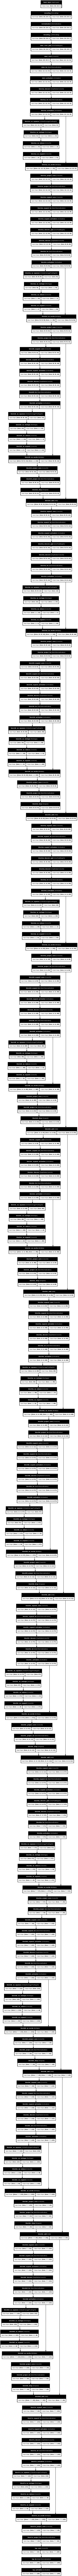

In [48]:
plot_model(ayush_effiecentnetB0_base, to_file=f'{working_dir}/effiecentNet_base_model_summary.png', show_shapes=True, show_layer_names=True)

### Final Model

In [49]:
ayushVision_EfficentNetB0_Model=Sequential()

In [50]:
ayushVision_EfficentNetB0_Model.add(Input(shape=input_shape))

In [51]:
ayushVision_EfficentNetB0_Model.add(ayush_effiecentnetB0_base)

#### Middle Layers

In [52]:
ayushVision_EfficentNetB0_Model.add(GlobalAveragePooling2D())

In [53]:
ayushVision_EfficentNetB0_Model.add(Dense(320, activation='relu', kernel_regularizer=l2(0.001)))
ayushVision_EfficentNetB0_Model.add(Dropout(0.3))

In [54]:
ayushVision_EfficentNetB0_Model.add(Dense(320, activation='relu', kernel_regularizer=l2(0.001)))
ayushVision_EfficentNetB0_Model.add(Dropout(0.3))

In [55]:
ayushVision_EfficentNetB0_Model.add(Dense(320, activation='relu',kernel_regularizer=l2(0.001)))
ayushVision_EfficentNetB0_Model.add(Dropout(0.3))

#### Last Layer

In [56]:
ayushVision_EfficentNetB0_Model.add(Dense(no_of_classes, activation='softmax'))

In [57]:
today_training_colref=today_ref.collection('Train')

## Model Compile

#### Optimizer

In [ ]:
#1e-4

In [58]:
optimizer = Adam(learning_rate=1e-4)

#### Compile

##### Variables

In [59]:
metrics=["accuracy",
        #  CategoricalAccuracy(name='categorical_accuracy'),  # Categorical accuracy
        # TopKCategoricalAccuracy(k=5, name='top_5_accuracy'),  # Top-5 accuracy
        # AUC(name='auc')
        ]
lossfn='categorical_crossentropy'

In [60]:
ayushVision_EfficentNetB0_Model.compile(
    optimizer=optimizer,
    loss=lossfn,
    metrics=metrics)

In [61]:
ayushVision_EfficentNetB0_Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 320)                 │         409,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 320)                 │         102,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 320)                 │         102,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │          10,272 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,675,203 (17.83 MB)

 Trainable params: 4,633,180 (17.67 MB)

 Non-trainable params: 42,023 (164.16 KB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.413432 to fit



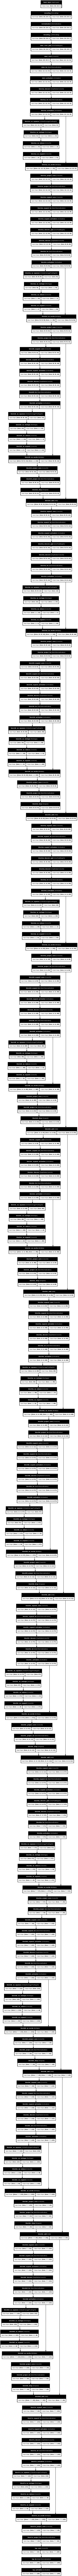

In [62]:
plot_model(ayush_effiecentnetB0_base, to_file=f'{working_dir}/effiecentNet_{epochs}_summary.png', show_shapes=True, show_layer_names=True)

In [63]:
summaryblob = bucket.blob(f"{storageLocation+document_id}/train/model_summary_{document_id}.jpg")
summaryblob.upload_from_filename(f'{working_dir}/effiecentNet_{epochs}_summary.png')
summaryblob.make_public()

In [64]:
summarybaseblob = bucket.blob(f"{storageLocation+document_id}/train/model_summary_base{document_id}.jpg")
summarybaseblob.upload_from_filename(f'{working_dir}/effiecentNet_base_model_summary.png')
summarybaseblob.make_public()

In [65]:
todat_fit_train_ref=today_training_colref.document('fit')

In [66]:
todat_fit_train_ref.set({
    'epochs':epochs,
    'loss':lossfn,
    'optimizer':optimizer.get_config(),
    'base_model':summarybaseblob.public_url,
    'model':summaryblob.public_url
})



update_time {
  seconds: 1726554227
  nanos: 10435000
}

In [67]:
checkpoint = ModelCheckpoint(f'{working_dir}/efficentnet/{epochs}best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1,write_graph=True,write_images=True)

### Trainning

In [68]:
model_history=ayushVision_EfficentNetB0_Model.fit(
    train_ds_gen,
    epochs=epochs,
    callbacks=[checkpoint,
               early_stopping,
               reduce_lr,tensorboard_callback
               ],
    verbose=1 , # Option to show training progress
    validation_data=val_ds_gen)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 9370s 26s/step - accuracy: 0.0774 - loss: 4.4883 - val_accuracy: 0.0369 - val_loss: 4.5150 - learning_rate: 1.0000e-04
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 184s 516ms/step - accuracy: 0.4313 - loss: 3.0700 - val_accuracy: 0.6352 - val_loss: 2.3534 - learning_rate: 1.0000e-04
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 183s 513ms/step - accuracy: 0.7048 - loss: 2.0478 - val_accuracy: 0.8849 - val_loss: 1.4415 - learning_rate: 1.0000e-04
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 183s 514ms/step - accuracy: 0.8124 - loss: 1.6745 - val_accuracy: 0.9199 - val_loss: 1.2863 - learning_rate: 1.0000e-04
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 183s 513ms/step - accuracy: 0.8604 - loss: 1.4876 - val_accuracy: 0.9330 - val_loss: 1.2070 - learning_rate: 1.0000e-04
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 184s 515ms/step - accuracy: 0.8966 - loss: 1.3286 - val_accuracy: 0.9431 - val_loss: 1.1489 - learning_rate: 1.0000e-04
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 183s 513ms/s

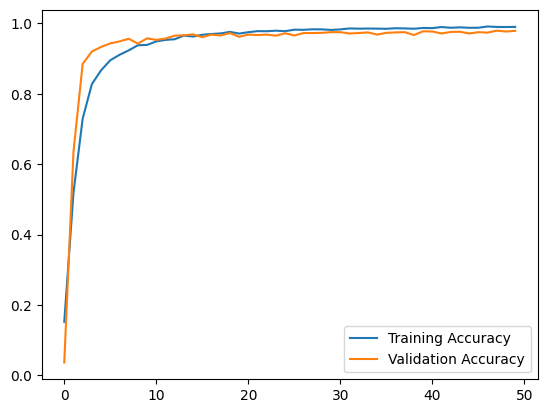

In [69]:
# Plot training history
plt.plot(model_history.history['accuracy'], label='Training Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.savefig(f"{working_dir}/efficent_net{epochs}_model_accuracy.jpg")
plt.show()

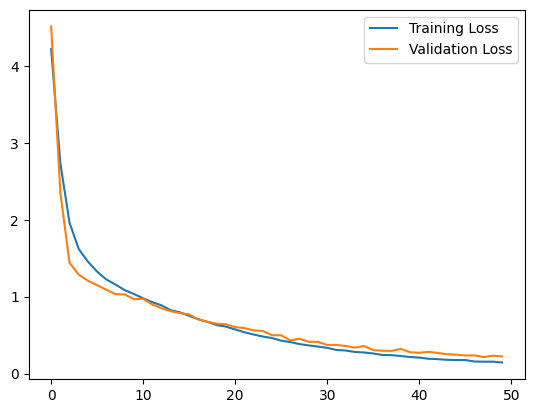

In [70]:
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.savefig(f"{working_dir}/efficent_net{epochs}_model_loss.jpg")
plt.show()

In [71]:
blob = bucket.blob(f"{storageLocation+document_id}/val/training_plot{document_id}.jpg")
blob.upload_from_filename(f'{working_dir}/efficent_net{epochs}_model_accuracy.jpg')
blob.make_public()

In [72]:
blobloss = bucket.blob(f"{storageLocation+document_id}/val/training_plot_loss{document_id}.jpg")
blobloss.upload_from_filename(f'{working_dir}/efficent_net{epochs}_model_loss.jpg')
blobloss.make_public()

In [73]:
validationref=today_ref.collection('Val')

In [74]:
valhistory_ref=validationref.document('history')
valaccuracy_ref=validationref.document('accuracy_plot')

In [75]:
valhistory_ref.set(
    model_history.history
)

update_time {
  seconds: 1726574778
  nanos: 452669000
}

In [77]:
valaccuracy_ref.set({
    'accuracy_url':blob.public_url,
    'loss_url':blobloss.public_url
})

update_time {
  seconds: 1726574778
  nanos: 592089000
}

### Evaluation

In [78]:
test_loss, test_accuracy = ayushVision_EfficentNetB0_Model.evaluate(test_ds_gen)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 2393s 24s/step - accuracy: 0.9778 - loss: 0.2290
Test Accuracy: 97.84%


In [79]:
testref=today_ref.collection('Test')

In [80]:
test_accuracy_loss=testref.document('test_accuracy_lost')
test_accuracy_loss.set({
    'accuracy':test_accuracy,
    'loss':test_loss
})

update_time {
  seconds: 1726577249
  nanos: 953428000
}

In [81]:
modelref=today_ref.collection('Model')

In [82]:
ayushVision_EfficentNetB0_Model.save(f'{working_dir}/efficent_net_{epochs}.h5',)

In [83]:
ayushVision_EfficentNetB0_Model.save_weights(f'{working_dir}/efficent_net_{epochs}.weights.h5')

In [84]:
savemodel=modelref.document('model')

In [85]:
blob = bucket.blob(f"{storageLocation+document_id}/model/efficent_net_root_{epochs}.h5")
blob.upload_from_filename(f'{working_dir}/efficent_net_{epochs}.h5')
blob.make_public()
h5model=blob.public_url

In [86]:
savemodel.set({'model':h5model})

update_time {
  seconds: 1726577260
  nanos: 672984000
}

In [87]:
blob = bucket.blob(f"{storageLocation+document_id}/model/weights/efficent_net_weights_{epochs}.weights.h5")
blob.upload_from_filename(f'{working_dir}/efficent_net_{epochs}.weights.h5')
blob.make_public()
h5modelweights=blob.public_url

In [88]:
savemodel.update({
    'weights':h5modelweights
})

update_time {
  seconds: 1726577264
  nanos: 575780000
}

In [89]:
classnames=os.listdir(dataset_train_dir)

In [90]:
predictImagePath=os.path.join(dataset_dir,'predicts')

In [91]:
prdictsImages=list(map(lambda x:os.path.join(predictImagePath,x),os.listdir(predictImagePath)))

In [92]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)  # Resize image to target size (224x224 by default)
    img_array = image.img_to_array(img)                      # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)            # Add batch dimension (required by the model)
    img_array /= 255.0                                       # Normalize the image to [0, 1] range
    return img_array

In [93]:
predictions = []
for img_path in prdictsImages:
    img_array = load_and_preprocess_image(img_path)
    preds = ayushVision_EfficentNetB0_Model.predict(img_array)
    class_index = np.argmax(preds)
    confidence = preds[0, class_index]
    class_label = list(train_ds_gen.class_indices.keys())[class_index]
    predictions.append((img_path, class_label, confidence))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [94]:
os.makedirs(f"{working_dir}/prdict/")

In [95]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function to plot images
def plot_images(predictions, images_per_row=5):
    num_images = len(predictions)
    num_rows = (num_images + images_per_row - 1) // images_per_row

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3*num_rows))
    axes = axes.flatten()

    for img_idx, (img_path, class_label, confidence) in enumerate(predictions):
        img = mpimg.imread(img_path)
        axes[img_idx].imshow(img)
        axes[img_idx].set_title(f'{class_label}\n{confidence:.2f}')
        axes[img_idx].axis('off')

    # Hide any unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'{working_dir}/prdict/predictImmage.png')
    plt.show()

# Plot images
plot_images(predictions, images_per_row=10)


In [ ]:
blob = bucket.blob(f"{storageLocation+document_id}/predicts/efficent_net_prdicts_{epochs}.png")
blob.upload_from_filename(f'{working_dir}/prdict/predictImmage.png')
blob.make_public()
h5modelweights=blob.public_url

In [ ]:
savemodel.update({'predicts':h5modelweights})

update_time {
  seconds: 1726496306
  nanos: 573483000
}

In [ ]:
train_ds_gen.class_indices.keys()

dict_keys(['AdamantCreeper', 'Alovera', 'Betel', 'Black-HoneyShrub', 'Calotropisgigantea', 'Caster', 'Cinnamon', 'Henna', 'Hibiscus', 'HolyBasil', 'Indianacalypha', 'Landrina', 'Lemongrass', 'MiracleLeaf', 'MountainKnotgrass', 'Neem', 'Oregano', 'Pedaliummurex', 'RedPeaEggplant', 'RingwormPlant', 'Seedsunderleaves', 'SleepyPlant', 'ThornApple', 'Vitexnegundo', 'WildTurmaric', 'ginger', 'indian Mallow', 'ivy gourd', 'lime', 'longPepper', 'tallperennialgrass', 'turmeric'])

In [ ]:
class_names = train_ds_gen.class_indices.keys()  # This is where the class names are fetched

# Path to the labels directory where you want to save the txt file (in final/train/labels/)
labels_path = f'{working_dir}/prdict'  # Update the path to your 'labels' folder

# File where you will write the class names
class_txt_file = os.path.join(labels_path, 'effiecentnetlabels.txt')

# Write class names to the file
with open(class_txt_file, 'w') as f:
    for class_name in class_names:
        f.write(f"{class_name}\n")  # Write each class name on a new line

print(f"Class names have been written to {class_txt_file}")

Class names have been written to /content/drive/MyDrive/AYUSHVISION/ready/2024_09_16_09_50/prdict/effiecentnetlabels.txt


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(ayushVision_EfficentNetB0_Model)

# Optional: Optimize the model for size and speed
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the converted model
with open(f'{working_dir}/efficent_net{epochs}.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpbt4s5ea9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 32), dtype=tf.float32, name=None)
Captures:
  140010906267216: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140010906266688: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  140011213241360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140010906264048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140010906269328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140011213441504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140011213453824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140010906262640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140010906256656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140010906258064: TensorSpec(shape=(), dtype=tf.resource, name

In [ ]:
blob = bucket.blob(f"{storageLocation+document_id}/model/ayush_efficent_net_{epochs}.tflite")
blob.upload_from_filename(f'{working_dir}/efficent_net{epochs}.tflite')
blob.make_public()
h5modelweights=blob.public_url

In [ ]:
savemodel.update({'tflite':h5modelweights})

update_time {
  seconds: 1726496324
  nanos: 466299000
}